In [79]:
#import libraries
import pandas as pd
import json
from glob import glob
import time

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib
%matplotlib inline

import textmining as tm
import wordcloud
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer
# the following two lines set up our visualization settings
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = [10, 6]

In [80]:
#functions
def print_with_sleep(message, sleep_time):
    print(message)
    time.sleep(sleep_time)

def convert_owners_to_average(test):
    new = test["owners"].str.split(" .. ", n = 1, expand = True)
    test["owners"]= new[0]
    test["ownerstwo"]=new[1]
    test.owners.replace(',','', regex=True, inplace=True)
    test.ownerstwo.replace(',','', regex=True, inplace=True)
    test["owners"]=(test.owners.astype(int)+test.ownerstwo.astype(int)).div(2)
    test = test.drop('ownerstwo', 1)
    return test

import math
def create_popularity_column(data_df):
    #Our measure of how popular a game is:
    # a good game (based on domain knowledge)
    # userscore * owners
    data_df['popularity'] = (data_df['userscore'] * data_df['owners'].apply(math.sqrt))
    #data_df['popularity'] = data_df['popularity'].apply(math.sqrt)
    return data_df

def create_is_popular_column(data_df, popularity_threshold):
    #We say that only 1000 games are actually popular, and this is the ones with highest popularity values
    data_df['is_popular'] = data_df['popularity'] > popularity_threshold
    return data_df

def tag_frequency(dataset):
    return dataset.sum() / len(dataset) * 100

def item_frequency_plot(dataset, support):
    frequencies = dataset.sum() / len(dataset)
    freq = frequencies[frequencies > support]
    return freq * 100


In [81]:
# Run this cell to import the modules and set up some stuff
#From lab1 & 2
import pandas as pd
import textmining as tm
import wordcloud
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer
# the following two lines set up our visualization settings
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = [10, 6]

import pandas as pd
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from graphviz import Source
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
from client.api.notebook import Notebook

In [82]:
#read clean data
clean_data = pd.read_csv("cleaned_data.csv")
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42631 entries, 0 to 42630
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       42631 non-null  int64  
 1   appid            42631 non-null  int64  
 2   name             42623 non-null  object 
 3   developer        42484 non-null  object 
 4   publisher        42561 non-null  object 
 5   positive         42631 non-null  int64  
 6   negative         42631 non-null  int64  
 7   userscore        42575 non-null  float64
 8   owners           42631 non-null  object 
 9   average_forever  42631 non-null  int64  
 10  average_2weeks   42631 non-null  int64  
 11  median_forever   42631 non-null  int64  
 12  median_2weeks    42631 non-null  int64  
 13  price            42631 non-null  float64
 14  initialprice     42631 non-null  float64
 15  ccu              42631 non-null  int64  
 16  languages        42609 non-null  object 
 17  tags        

In [83]:
#read clean data (put this there to only have to re-run this window)
clean_data = pd.read_csv("cleaned_data.csv")
clean_data.info()

#Remove Unnamed: 0 column (BUG from to_csv and our json data?)
if 'Unnamed: 0' in clean_data.columns:
    clean_data = clean_data.drop('Unnamed: 0', 1)
    
#Remove score_rank, this is steams own categorical attribute which is missing in most of our data
if 'score_rank' in clean_data.columns:
    clean_data = clean_data.drop('score_rank', 1)

#Create new columns that are useful

#Convert owners to average between the intervalls(category)
#if df['a'].dtype != np.number:
clean_data = convert_owners_to_average(clean_data)

#Create new column 'popularity'
clean_data = create_popularity_column(clean_data)

#Create new column 'is_popular' based on popularity
popularity_threshold = clean_data.sort_values(by = ['popularity'], ascending=False).iloc[2000]['popularity']
clean_data = create_is_popular_column(clean_data, popularity_threshold)

#Create columns with our chosen 13 tags (decided by frequency from previous exploration)
clean_data.tags = clean_data.tags.astype(str)
clean_data['action'] = clean_data.tags.str.contains('Action', case=False, regex=True)
clean_data['singleplayer'] = clean_data.tags.str.contains('Singleplayer', case=False, regex=True)
clean_data['multiplayer'] = clean_data.tags.str.contains('Multiplayer', case=False, regex=True)
clean_data['adventure'] = clean_data.tags.str.contains('Adventure', case=False, regex=True)
clean_data['co-op'] = clean_data.tags.str.contains('co-op', case=False, regex=True)
clean_data['rpg'] = clean_data.tags.str.contains('rpg', case=False, regex=True)
clean_data['strategy'] = clean_data.tags.str.contains('strategy', case=False, regex=True)
clean_data['open_world'] = clean_data.tags.str.contains('Open World', case=False, regex=True)
clean_data['atmospheric'] = clean_data.tags.str.contains('atmospheric', case=False, regex=True)
clean_data['shooter'] = clean_data.tags.str.contains('shooter', case=False, regex=True)
clean_data['horror'] = clean_data.tags.str.contains('horror', case=False, regex=True)
clean_data['survival'] = clean_data.tags.str.contains('survival', case=False, regex=True)
clean_data['simulation'] = clean_data.tags.str.contains('simulation', case=False, regex=True)

#Create categorical attribute price_range based on price
clean_data.price = clean_data.price.astype(int)
clean_data['price_range'] = pd.cut(clean_data.price, [-3/100, 0.0005/100, 2000/100, 5000/100, 99999/100], labels =['free', 'cheap', 'normal', 'expensive'])


#BUG that we still have null-values, so we remove the columns with null in them
#clean_data = clean_data.dropna(how='any',axis=1) 
#DON'T USE THIS RIGHT NOW!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42631 entries, 0 to 42630
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       42631 non-null  int64  
 1   appid            42631 non-null  int64  
 2   name             42623 non-null  object 
 3   developer        42484 non-null  object 
 4   publisher        42561 non-null  object 
 5   positive         42631 non-null  int64  
 6   negative         42631 non-null  int64  
 7   userscore        42575 non-null  float64
 8   owners           42631 non-null  object 
 9   average_forever  42631 non-null  int64  
 10  average_2weeks   42631 non-null  int64  
 11  median_forever   42631 non-null  int64  
 12  median_2weeks    42631 non-null  int64  
 13  price            42631 non-null  float64
 14  initialprice     42631 non-null  float64
 15  ccu              42631 non-null  int64  
 16  languages        42609 non-null  object 
 17  tags        

In [84]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42631 entries, 0 to 42630
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   appid            42631 non-null  int64   
 1   name             42623 non-null  object  
 2   developer        42484 non-null  object  
 3   publisher        42561 non-null  object  
 4   positive         42631 non-null  int64   
 5   negative         42631 non-null  int64   
 6   userscore        42575 non-null  float64 
 7   owners           42631 non-null  float64 
 8   average_forever  42631 non-null  int64   
 9   average_2weeks   42631 non-null  int64   
 10  median_forever   42631 non-null  int64   
 11  median_2weeks    42631 non-null  int64   
 12  price            42631 non-null  int32   
 13  initialprice     42631 non-null  float64 
 14  ccu              42631 non-null  int64   
 15  languages        42609 non-null  object  
 16  tags             42631 non-null  object 

In [85]:
#Exploration of our WHOLE data set
whole_data = clean_data
shape = whole_data.shape
shape_string = "We have {nr_attributes} attributes and {nr_games} games in our data set after cleaning the data."
print(shape_string.format(nr_attributes=shape[1], nr_games=shape[0]))


We have 33 attributes and 42631 games in our data set after cleaning the data.


In [119]:
#Sort by each quantative attribute and compare top 2000 games for each attribute
nr_games_in_each_attr = 2000
#positive
positive_top = list(clean_data.sort_values(by='positive', ascending=False).appid.head(nr_games_in_each_attr))
#negative
negative_top = list(clean_data.sort_values(by='negative', ascending=True).appid.head(nr_games_in_each_attr))
#userscore
userscore_top = list(clean_data.sort_values(by='userscore', ascending=False).appid.head(nr_games_in_each_attr))
#owners
owners_top = list(clean_data.sort_values(by='owners', ascending=False).appid.head(nr_games_in_each_attr))
#average_forever
average_forever_top = list(clean_data.sort_values(by='average_forever', ascending=False).appid.head(nr_games_in_each_attr))
#average_2weeks
average_2weeks_top = list(clean_data.sort_values(by='average_2weeks', ascending=False).appid.head(nr_games_in_each_attr))
#median_forever
median_forever_top = list(clean_data.sort_values(by='median_forever', ascending=False).appid.head(nr_games_in_each_attr))
#median_2weeks
median_2weeks_top = list(clean_data.sort_values(by='median_2weeks', ascending=False).appid.head(nr_games_in_each_attr))
#price
price_top = list(clean_data.sort_values(by='price', ascending=False).appid.head(nr_games_in_each_attr))
#initialprice
initialprice_top = list(clean_data.sort_values(by='initialprice', ascending=False).appid.head(nr_games_in_each_attr))
#ccu
ccu_top = list(clean_data.sort_values(by='ccu', ascending=False).appid.head(nr_games_in_each_attr))
#popularity
popularity_top = list(clean_data.sort_values(by='popularity', ascending=False).appid.head(nr_games_in_each_attr))

def count_game_occurences(attr_lists):
    count_dict = dict()
    for attr_list in attr_lists:
        for appid in attr_list:
            if appid not in count_dict:
                count_dict[appid] = 1
            else:
                count_dict[appid] += 1
    return count_dict

games_found_in_top_attr = count_game_occurences([positive_top, negative_top, userscore_top, owners_top, average_forever_top, average_2weeks_top, median_forever_top, median_2weeks_top, price_top, initialprice_top, ccu_top, popularity_top])



df_count_top = pd.DataFrame([games_found_in_top_attr]).transpose()
df_count_top.columns = ['count']
df_count_top['appid'] = df_count_top.index

df_count_top = df_count_top.set_index('appid').join(clean_data.set_index('appid'))
df_count_top = df_count_top.sort_values(by='popularity', ascending=False)


df_count_top.head(15)

,count,name,developer,publisher,positive,negative,userscore,owners,average_forever,average_2weeks,...,co-op,rpg,strategy,open_world,atmospheric,shooter,horror,survival,simulation,price_range
appid,,,,,,,,,,,,,,,,,,,,,
570,8,Dota 2,Valve,Valve,1344991,260528,0.837730,150000000.0,36023,1820,...,True,True,True,False,False,False,False,False,True,free
440,7,Team Fortress 2,Valve,Valve,771699,51686,0.937227,75000000.0,8377,2522,...,True,False,False,False,False,True,False,False,False,free
730,8,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,5301391,713807,0.881333,75000000.0,29195,1001,...,True,False,True,False,False,True,False,False,False,free
105600,8,Terraria,Re-Logic,Re-Logic,817927,17427,0.979138,35000000.0,7389,497,...,True,True,False,True,True,False,False,True,False,cheap
550,7,Left 4 Dead 2,Valve,Valve,541773,14739,0.973515,35000000.0,2154,160,...,True,False,False,False,False,True,True,True,False,cheap
4000,8,Garry's Mod,Facepunch Studios,Valve,732915,25880,0.965893,35000000.0,8556,493,...,True,False,False,False,False,True,False,False,True,cheap
945360,8,Among Us,Innersloth,Innersloth,544118,44163,0.924929,35000000.0,1245,147,...,True,False,False,False,False,False,False,True,False,cheap
304930,7,Unturned,Smartly Dressed Games,Smartly Dressed Games,416537,39101,0.914184,35000000.0,5869,3195,...,True,False,False,True,True,True,False,True,False,free
238960,7,Path of Exile,Grinding Gear Games,Grinding Gear Games,157499,15997,0.907796,35000000.0,7199,2545,...,True,True,False,False,False,False,True,False,False,free


In [87]:
#Tag analysis of all games
result_tags = clean_data[['action', 'singleplayer', 'multiplayer', 'adventure', 'co-op', 'rpg', 'strategy', 'open_world', 'atmospheric', 'shooter', 'horror', 'survival', 'simulation' ]]
tag_frequency(result_tags).sort_values()

open_world       7.238864
co-op            8.193568
survival         8.442213
horror          10.928667
shooter         11.665220
atmospheric     15.390209
multiplayer     16.068119
rpg             20.332622
simulation      20.714973
strategy        22.415613
adventure       43.421454
singleplayer    43.890596
action          46.930637
dtype: float64

<AxesSubplot:title={'center':'popularity'}, xlabel='price_range'>

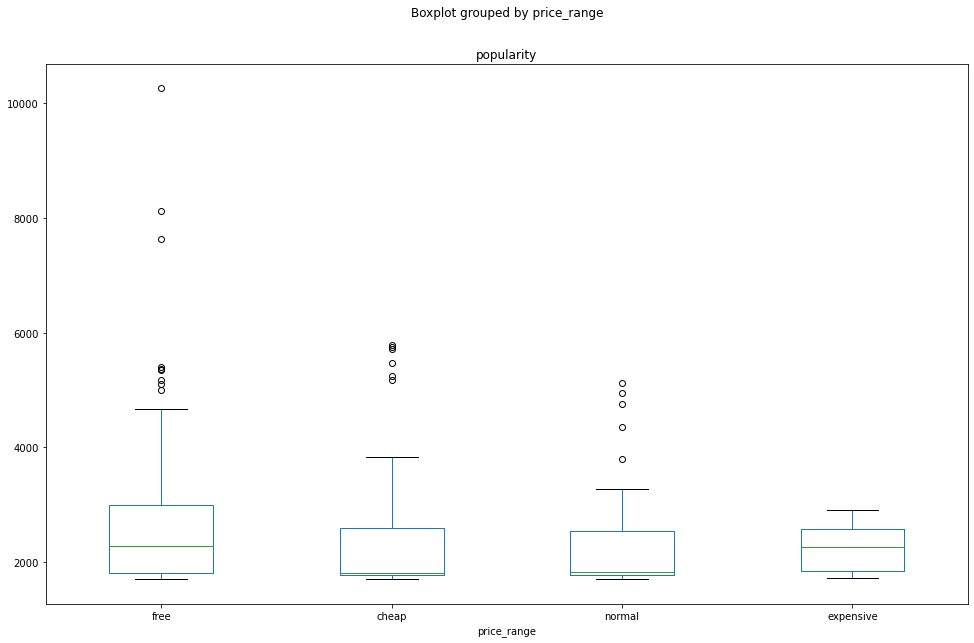

In [88]:
#Create boxplot of popularity vs price_range
plot_data = clean_data.sort_values('popularity', ascending=False)
plot_data = plot_data.head(250)
plot_data.boxplot(by = 'price_range', column = ['popularity'], grid = False, figsize = (16,10))

In [89]:
#Present tag % on whole data set
plot_data_tags = plot_data[['action', 'singleplayer', 'multiplayer', 'adventure', 'co-op', 'rpg', 'strategy', 'open_world', 'atmospheric', 'shooter', 'horror', 'survival', 'simulation' ]]
tag_frequency(plot_data_tags)

action          83.6
singleplayer    78.0
multiplayer     68.8
adventure       66.4
co-op           54.0
rpg             30.0
strategy        36.0
open_world      38.0
atmospheric     48.0
shooter         42.4
horror          20.0
survival        29.6
simulation      28.4
dtype: float64

In [90]:
import ast

def get_all_unique_tags(curr_tags, new_possible_tags):
    #set only allows unique values
    tags = set()
    return tags

def dict_get_keys_list(dict):
    return [*dict]

def all_game_tags_list(data_df, stop_tags=[]):
    tags_df = data_df[['appid', 'tags']]
    tag_list = list()
    for game_tags in tags_df['tags']:
        dict_data = ast.literal_eval(game_tags)
        #We don't care about how many people voted on the tag, just that it's there
        tags = [tag for tag in dict_get_keys_list(dict_data) if not tag in stop_tags]
        tag_list.append(tags)
    return tag_list
    


#As from lab 3, check tags that go together to make a popular game

#Create new dataframe with tags for all games
#Filter out the most 10000 popular games in the tags

tag_list = all_game_tags_list(clean_data)
#With tag_list we can create a sparse matrix using TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(tag_list).transform(tag_list)
tags = pd.DataFrame(te_ary, columns=te.columns_)
shape = tags.shape
shape_string = "We have {nr_tags} total number of tags amongst {nr_games} games in our data set."
print(shape_string.format(nr_tags=shape[1], nr_games=shape[0]))

We have 429 total number of tags amongst 42631 games in our data set.


In [91]:
tags.describe()

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,...,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
count,42631,42631,42631,42631,42631,42631,42631,42631,42631,42631,...,42631,42631,42631,42631,42631,42631,42631,42631,42631,42631
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,41971,41720,41873,32883,42172,40923,42580,38505,42394,41470,...,42542,42619,42568,42466,42375,42535,42162,42591,41350,42323


In [92]:
#Most tags assigned to a game
tags.sum(axis=1).max()

21

In [114]:
#Top 40 tags
tags.sum().sort_values(ascending=False)[:40]

Indie                 28306
Action                19258
Singleplayer          18711
Casual                17935
Adventure             17642
2D                     9748
Strategy               9287
Simulation             8831
RPG                    8059
Puzzle                 6884
Atmospheric            6561
Early Access           5653
Multiplayer            5608
Story Rich             5354
Pixel Graphics         5029
Arcade                 4427
First-Person           4385
Fantasy                4274
Colorful               4226
3D                     4126
Cute                   4097
Shooter                4037
Funny                  4029
Anime                  3999
Great Soundtrack       3951
Free to Play           3904
Retro                  3882
Exploration            3848
Platformer             3829
VR                     3827
Horror                 3821
Sci-fi                 3754
Difficult              3631
Family Friendly        3509
Female Protagonist     3204
Open World          

In [94]:
#Density of our dataset (isn't actually useful since tags denote what type of game it is and shouldn't overlap if they differ)
true_false_cells = tags.stack().value_counts()
dataset_density = true_false_cells[1] / (true_false_cells[0] + true_false_cells[1])
dataset_density

0.026269501182123452

In [95]:
#Frequencies of the tags
tag_frequency(tags).sort_values(ascending=False)

Indie           66.397692
Action          45.173700
Singleplayer    43.890596
Casual          42.070324
Adventure       41.383031
                  ...    
Hardware         0.021111
Boss Rush        0.016420
8-bit Music      0.014074
Masterpiece      0.009383
Batman           0.002346
Length: 429, dtype: float64

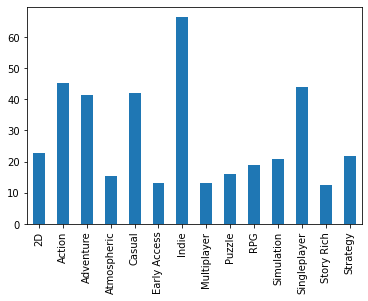

In [96]:
#Plot of tags
_ = item_frequency_plot(tags, 0.125).plot.bar()

In [97]:
#Create new dataframe with only popular games
popular_data = clean_data[clean_data['is_popular'] == True]
#Remove "rare" tags
stop_tags = tag_frequency(tags).sort_values(ascending=False)
stop_tags = stop_tags[stop_tags < 1]
stop_tags = list(dict(stop_tags).keys())

In [98]:
tag_list_popular = all_game_tags_list(popular_data, stop_tags)
#With tag_list we can create a sparse matrix using TransactionEncoder
te_p = TransactionEncoder()
te_ary_p = te_p.fit(tag_list_popular).transform(tag_list_popular)
tags_p = pd.DataFrame(te_ary_p, columns=te_p.columns_)
shape_p = tags_p.shape
shape_string_p = "We have {nr_tags} total number of tags amongst {nr_games} games in our popular data set."
print(shape_string.format(nr_tags=shape_p[1], nr_games=shape_p[0]))

We have 201 total number of tags amongst 2000 games in our data set.


In [99]:
#Measuring association rules for popular games

#Using apriori function
frequent_tags_together = apriori(tags_p, min_support=0.05, use_colnames=True)
frequent_tags_together

tags_p

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,3D,3D Platformer,4 Player Local,Abstract,...,Utilities,VR,VR Only,Violent,Visual Novel,Walking Simulator,War,Wargame,World War II,Zombies
0,True,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,True
4,False,False,False,False,False,False,False,False,False,False,...,True,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1996,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1997,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1998,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [100]:
tags_rules = association_rules(frequent_tags_together, metric="confidence", min_threshold=0.1)
tags_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Action),(2D),0.7120,0.2445,0.1435,0.201545,0.824315,-0.030584,0.946202
1,(2D),(Action),0.2445,0.7120,0.1435,0.586912,0.824315,-0.030584,0.697188
2,(Adventure),(2D),0.5980,0.2445,0.1440,0.240803,0.984878,-0.002211,0.995130
3,(2D),(Adventure),0.2445,0.5980,0.1440,0.588957,0.984878,-0.002211,0.978000
4,(Atmospheric),(2D),0.4065,0.2445,0.0755,0.185732,0.759639,-0.023889,0.927827
...,...,...,...,...,...,...,...,...,...
41251,(Co-op),"(FPS, Shooter, Singleplayer, Multiplayer, Firs...",0.3700,0.1065,0.0750,0.202703,1.903312,0.035595,1.120661
41252,(Shooter),"(FPS, Co-op, Singleplayer, Multiplayer, First-...",0.2735,0.0830,0.0750,0.274223,3.303892,0.052299,1.263474
41253,(Multiplayer),"(FPS, Co-op, Shooter, Singleplayer, First-Pers...",0.5745,0.0765,0.0750,0.130548,1.706514,0.031051,1.062164
41254,(First-Person),"(FPS, Co-op, Shooter, Singleplayer, Multiplaye...",0.2860,0.0840,0.0750,0.262238,3.121878,0.050976,1.241592


In [101]:
tags_rules["num_antecedents"] = tags_rules["antecedents"].apply(lambda x: len(x))
tags_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,num_antecedents
0,(Action),(2D),0.7120,0.2445,0.1435,0.201545,0.824315,-0.030584,0.946202,1
1,(2D),(Action),0.2445,0.7120,0.1435,0.586912,0.824315,-0.030584,0.697188,1
2,(Adventure),(2D),0.5980,0.2445,0.1440,0.240803,0.984878,-0.002211,0.995130,1
3,(2D),(Adventure),0.2445,0.5980,0.1440,0.588957,0.984878,-0.002211,0.978000,1
4,(Atmospheric),(2D),0.4065,0.2445,0.0755,0.185732,0.759639,-0.023889,0.927827,1
...,...,...,...,...,...,...,...,...,...,...
41251,(Co-op),"(FPS, Shooter, Singleplayer, Multiplayer, Firs...",0.3700,0.1065,0.0750,0.202703,1.903312,0.035595,1.120661,1
41252,(Shooter),"(FPS, Co-op, Singleplayer, Multiplayer, First-...",0.2735,0.0830,0.0750,0.274223,3.303892,0.052299,1.263474,1
41253,(Multiplayer),"(FPS, Co-op, Shooter, Singleplayer, First-Pers...",0.5745,0.0765,0.0750,0.130548,1.706514,0.031051,1.062164,1
41254,(First-Person),"(FPS, Co-op, Shooter, Singleplayer, Multiplaye...",0.2860,0.0840,0.0750,0.262238,3.121878,0.050976,1.241592,1


In [102]:
tags_rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,num_antecedents
count,41256.000000,41256.000000,41256.000000,41256.000000,41256.000000,41256.000000,4.125600e+04,41256.000000
mean,0.227652,0.270575,0.071427,0.440292,1.916616,0.024523,inf,2.315954
std,0.158282,0.195060,0.029122,0.250771,0.983102,0.019422,NaN,1.002415
min,0.050000,0.050000,0.050000,0.100087,0.473328,-0.066648,3.545426e-01,1.000000
25%,0.110500,0.126000,0.054500,0.231104,1.259904,0.013750,1.073929e+00,2.000000
50%,0.179000,0.204000,0.061500,0.376384,1.635735,0.025253,1.223823e+00,2.000000
75%,0.289000,0.337500,0.077000,0.625648,2.275571,0.035868,1.647455e+00,3.000000
max,0.839000,0.839000,0.597000,1.000000,10.991149,0.136620,inf,6.000000


In [117]:
#Top 15 best rules
tags_rules[(tags_rules.num_antecedents >= 3) 
              & (tags_rules.confidence > 0.6)
              & (tags_rules.support > 0.05)
          & (tags_rules.lift > 2)].sort_values('support', ascending=False).head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,num_antecedents
15368,"(Adventure, Atmospheric, Singleplayer)",(Story Rich),0.2890,0.3040,0.1850,0.640138,2.105718,0.097144,1.934077,3
12050,"(FPS, First-Person, Action)",(Shooter),0.1840,0.2735,0.1630,0.885870,3.239011,0.112676,6.365524,3
12052,"(FPS, Action, Shooter)",(First-Person),0.1780,0.2860,0.1630,0.915730,3.201854,0.112092,8.472800,3
12053,"(First-Person, Action, Shooter)",(FPS),0.1700,0.2160,0.1630,0.958824,4.438998,0.126280,19.040000,3
11398,"(Multiplayer, Online Co-Op, Action)",(Co-op),0.1710,0.3700,0.1570,0.918129,2.481429,0.093730,7.695000,3
16926,"(Adventure, Great Soundtrack, Singleplayer)",(Story Rich),0.2505,0.3040,0.1530,0.610778,2.009140,0.076848,1.788185,3
12067,"(First-Person, Action, Singleplayer)",(FPS),0.2135,0.2160,0.1525,0.714286,3.306878,0.106384,2.744000,3
12066,"(FPS, Action, Singleplayer)",(First-Person),0.1690,0.2860,0.1525,0.902367,3.155129,0.104166,7.313091,3
12374,"(Singleplayer, Action, Shooter)",(FPS),0.2245,0.2160,0.1455,0.648107,3.000495,0.097008,2.227949,3
12372,"(FPS, Action, Singleplayer)",(Shooter),0.1690,0.2735,0.1455,0.860947,3.147886,0.099278,5.224617,3


action          1778
singleplayer    1678
multiplayer     1564
adventure       1317
op              1312
person          1155
indie            943
rpg              940
atmospheric      813
strategy         810
shooter          794
great            788
soundtrack       788
world            737
open             675
horror           645
rich             608
story            608
third            583
based            558
casual           549
2d               548
simulation       532
funny            509
survival         487
fantasy          477
fps              432
free             427
play             427
difficult        421
fi               412
sci              412
local            400
online           397
turn             394
sandbox          393
puzzle           376
platformer       350
gore             328
classic          305
comedy           304
dark             302
exploration      282
building         275
tactical         272
massively        248
pvp              245
female       

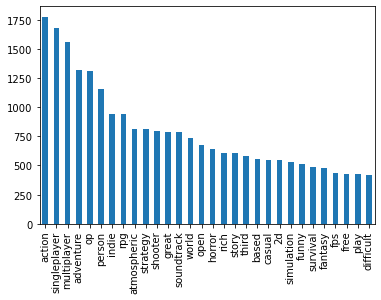

In [104]:
#Wordcloud most popular tags
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(max_font_size=40)

def create_term_document_matrix(corpus, min_df=1):
    cvec = CountVectorizer(min_df=min_df, stop_words=tm.stopwords)
    tfmatrix = cvec.fit_transform(corpus)
    return pd.DataFrame(data=tfmatrix.toarray(), columns=cvec.get_feature_names())

def plot_top_words(tags, num_word_instances, top_words):
    tdm_df = create_term_document_matrix(tags, min_df=2)
    word_frequencies = tdm_df[[x for x in tdm_df.columns if len(x) > 1]].sum()
    sorted_words = word_frequencies.sort_values(ascending=False)
    top_sorted_words = sorted_words[:num_word_instances]
    top_sorted_words[:top_words].plot.bar()
    return top_sorted_words

def list_of_list_to_list_of_str(list_of_list):
    list_of_str = list()
    for item in list_of_list:
        list_of_str.append(' '.join(item))
    return list_of_str

#Create new dataframe with only popular games
popular_data = clean_data[clean_data['is_popular'] == True]
#Remove "rare" tags
stop_tags = tag_frequency(tags).sort_values(ascending=False)
stop_tags = stop_tags[stop_tags < 1]
stop_tags = list(dict(stop_tags).keys())
tag_list_popular = all_game_tags_list(popular_data, stop_tags)
tag_list_popular = list_of_list_to_list_of_str(tag_list_popular)
tag_list_popular

tag_list_popular_counted_tags = plot_top_words(tag_list_popular, 50, 30)
tag_list_popular_counted_tags



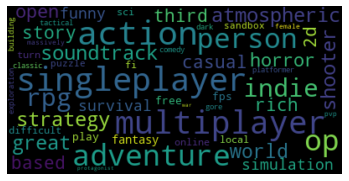

In [105]:
wordcloud.fit_words(tag_list_popular_counted_tags.to_dict())
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()